# Regional Temperature Changes

Preprocessing ssp245 with historical baseline

### Preprocessing Data

In [1]:
#imports
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [5]:
df_tas_hist=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp245=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'    & member_id=='r1i1p1f1'")

#  assemble a set of models (source_id) for each experiment + variable combination
models_tas_hist  =set(df_tas_hist.source_id)    # all models that have temperature in the historical simulations
models_tas_ssp245=set(df_tas_ssp245.source_id)  # all models that have temperature in the ssp245     simulations

# let's only keep the models that have all the runs (the intersection of the set)
source_set = set.intersection(models_tas_hist, models_tas_ssp245)
source_list=list(source_set)
print(len(models_tas_hist))
print(len(models_tas_ssp245))
print(len(source_list))

55
34
34


In [6]:
source_list.remove('NorESM2-LM')
source_list.remove('MPI-ESM1-2-HR')
source_list.remove('E3SM-1-1')
source_list.remove('AWI-CM-1-1-MR')
source_list.remove('MPI-ESM1-2-LR')

In [7]:
print(len(source_list))
source_list

29


['MRI-ESM2-0',
 'KIOST-ESM',
 'FGOALS-f3-L',
 'CIESM',
 'CMCC-ESM2',
 'EC-Earth3-Veg-LR',
 'CAS-ESM2-0',
 'CESM2-WACCM',
 'FGOALS-g3',
 'INM-CM5-0',
 'GFDL-CM4',
 'FIO-ESM-2-0',
 'INM-CM4-8',
 'TaiESM1',
 'EC-Earth3',
 'IITM-ESM',
 'NorESM2-MM',
 'ACCESS-CM2',
 'EC-Earth3-Veg',
 'EC-Earth3-CC',
 'KACE-1-0-G',
 'GFDL-ESM4',
 'CAMS-CSM1-0',
 'BCC-CSM2-MR',
 'IPSL-CM6A-LR',
 'NESM3',
 'CMCC-CM2-SR5',
 'MIROC6',
 'CanESM5']

In [8]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [9]:
#time index to assign model times to
new_time_index=pd.date_range('1850-01-01', '2099-12-31', freq='ME')
new_time_index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [10]:
#regrid to common 1x1 grid
new_lats=np.arange(-87,88)
new_lons=np.arange(1,359)

### 2.2 Multiple Models

In [11]:
gcm_list = ['MRI-ESM2-0',
 'KIOST-ESM',
 'FGOALS-f3-L',
 'CIESM',
 'CMCC-ESM2']

In [12]:
#load multiple models
ds_list = list()
for source in gcm_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp245_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
    #compute difference between avg over years 2089-2099 and years 1989-1999
    hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
    ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
    dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
    ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
    ds_interp.assign_coords(model = source)
    print(ds_interp)
    ds_list.append(ds_interp)
    #print(ds_list)
gcm_obs = xr.concat(ds_list, dim = 'model', coords = 'minimal',compat='override')
gcm_obs

<xarray.DataArray 'tas' (lat: 175, lon: 358)>
dask.array<chunked_aware_interpnd, shape=(175, 358), dtype=float32, chunksize=(175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
<xarray.DataArray 'tas' (lat: 175, lon: 358)>
dask.array<chunked_aware_interpnd, shape=(175, 358), dtype=float32, chunksize=(175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
<xarray.DataArray 'tas' (lat: 175, lon: 358)>
dask.array<chunked_aware_interpnd, shape=(175, 358), dtype=float32, chunksize=(175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6

<xarray.DataArray 'tas' (model: 5, lat: 175, lon: 358)>
dask.array<concatenate, shape=(5, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
Dimensions without coordinates: model

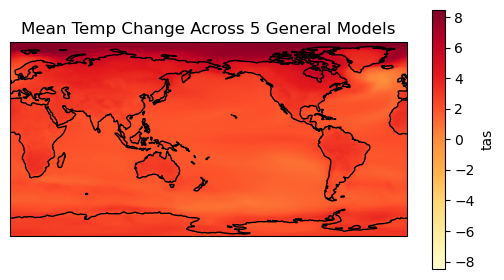

In [13]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
gcm_obs_mean = gcm_obs.mean(dim='model') #took mean across models to eliminate one dimension and mash all model data tg -> 2D now
gcm_obs_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})
plt.title('Mean Temp Change Across 5 General Models')
plt.show()

In [14]:
ds_list = list()
for source in source_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp245_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
    hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
    ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
    dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
    ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
    ds_interp= ds_interp.assign_coords(model = source)
    #print(ds_interp)
    ds_list.append(ds_interp)
ds_all_reg = xr.concat(ds_list, dim = 'model', coords = 'minimal',compat='override')
ds_all_reg

<xarray.DataArray 'tas' (model: 29, lat: 175, lon: 358)>
dask.array<concatenate, shape=(29, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U16 'MRI-ESM2-0' 'KIOST-ESM' ... 'MIROC6' 'CanESM5'

### Adding 12 Models

In [31]:
#make a separate list to concat with ds_all_reg
ds_12_models_list = list()
#query to individual model
df_hist_tas = df.query(  "source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [33]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-G' & member_id == 'r1i1p3f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'GISS-E2-1-G' & member_id == 'r1i1p3f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [35]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-H' & member_id == 'r1i1p3f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'GISS-E2-1-H' & member_id == 'r1i1p3f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [37]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'CNRM-CM6-1-HR' & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'CNRM-CM6-1-HR' & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [39]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'CESM2' & member_id == 'r4i1p1f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'CESM2' & member_id == 'r4i1p1f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [41]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [42]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'MCM-UA-1-0' & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'MCM-UA-1-0' & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#rename latitude and longitude to lat/lon for consistency
ds_hist_tas = ds_hist_tas.rename({'latitude': 'lat', 'longitude': 'lon'})
ds_ssp245_tas = ds_ssp245_tas.rename({'latitude': 'lat', 'longitude': 'lon'})
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [44]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'UKESM1-0-LL' & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'UKESM1-0-LL' & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [46]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'ACCESS-ESM1-5' & member_id == 'r31i1p1f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'ACCESS-ESM1-5' & member_id == 'r31i1p1f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [48]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'MIROC-ES2L' & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp245_tas = df.query("source_id == 'MIROC-ES2L' & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp245'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp245_tas =load_zarr_dset(df_ssp245_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp245_tas= ds_ssp245_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp245_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [49]:
ds_12_models = xr.concat(ds_12_models_list, dim = 'model', coords = 'minimal', compat = 'override')
ds_12_models = ds_12_models.drop_vars('height')
ds_12_models

<xarray.DataArray 'tas' (model: 10, lat: 175, lon: 358)>
dask.array<concatenate, shape=(10, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U13 'CanESM5-CanOE' 'GISS-E2-1-G' ... 'MIROC-ES2L'

In [51]:
ds_all_41 = xr.concat([ds_12_models, ds_all_reg], dim = 'model', coords = 'minimal', compat = 'override')
ds_all_41 = ds_all_41.drop_vars('height')
ds_all_41

<xarray.DataArray 'tas' (model: 39, lat: 175, lon: 358)>
dask.array<concatenate, shape=(39, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U16 'CanESM5-CanOE' 'GISS-E2-1-G' ... 'MIROC6' 'CanESM5'

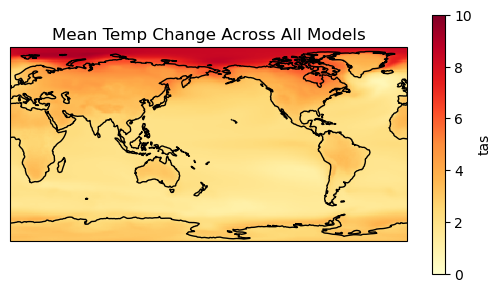

In [52]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_all_reg_mean = ds_all_41.mean(dim='model') #took mean across models
img = ds_all_reg_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), vmin = 0, vmax = 10, cbar_kwargs = {"shrink": 0.7})
img.colorbar.set_ticks(np.arange(0,12,2))
plt.title('Mean Temp Change Across All Models')
plt.show()

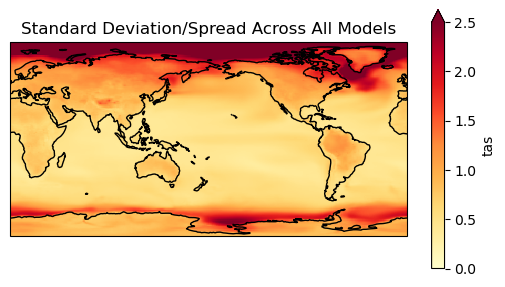

In [53]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_all_reg_std = ds_all_41.std(dim='model') #took mean across models
img = ds_all_reg_std.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), vmin=0, vmax=2.5, cbar_kwargs = {"shrink": 0.7})
img.colorbar.set_ticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
plt.title('Standard Deviation/Spread Across All Models')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.show()

In [54]:
#saving to netcdf file
ds_all_41.to_netcdf("processed_tas_regional_ssp245_data.nc", mode = 'w', format = "NETCDF4", engine = 'netcdf4')